# **Predicting Stock Price with LSTM**
**Ticker Symbol**: `SIA1.SG`

## **Import Libraries and Load Dataset**

In [1]:

# import relevant libraries
import yfinance as yf
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError, R2Score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [2]:
# set random seed
n = 42
random.seed(n)
np.random.seed(n)
tf.random.set_seed(n)

In [3]:
ticker = 'SIA1.SG'
data = yf.download(ticker, start="2014-01-01", end="2021-12-31", multi_level_index=False)
target = yf.download(ticker, start="2022-01-01", end="2022-12-31", multi_level_index=False)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## **Exploratory Data Analysis**

In [4]:
display(data.head())
print(f"Size: {data.shape}")

display(target.head())
print(f"Size: {target.shape}")

,Close,High,Low,Open,Volume
Date,,,,,
2014-01-02,2.446534,2.446534,2.446534,2.446534,0
2014-01-03,2.422094,2.422094,2.422094,2.422094,0
2014-01-06,2.423337,2.428308,2.423337,2.428308,4357
2014-01-07,2.423337,2.423337,2.423337,2.423337,0
2014-01-08,2.405524,2.405524,2.405524,2.405524,0


Size: (2029, 5)


,Close,High,Low,Open,Volume
Date,,,,,
2022-01-03,2.735904,2.735904,2.614489,2.614489,500
2022-01-04,2.646866,2.646866,2.646866,2.646866,0
2022-01-05,2.646866,2.646866,2.646866,2.646866,0
2022-01-06,2.582111,2.582111,2.582111,2.582111,0
2022-01-07,2.614488,2.614488,2.614488,2.614488,0


Size: (257, 5)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2029 entries, 2014-01-02 to 2021-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2029 non-null   float64
 1   High    2029 non-null   float64
 2   Low     2029 non-null   float64
 3   Open    2029 non-null   float64
 4   Volume  2029 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 95.1 KB


There are no missing values within `data`, and the dtype for each column is correct.

In [6]:
data.describe()

,Close,High,Low,Open,Volume
count,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000
mean,2.921725,2.931782,2.911803,2.921495,342.693445
std,0.461861,0.459916,0.465033,0.462341,3004.854859
min,1.610784,1.610784,1.610784,1.610784,0.000000
25%,2.557828,2.565470,2.549734,2.557828,0.000000
50%,3.097595,3.104350,3.089113,3.097878,0.000000
75%,3.270833,3.278928,3.263065,3.272323,0.000000
max,3.708471,3.718441,3.708471,3.718441,86280.000000


### **Drop irrelevant features**
i.e., Keep only `High` and `Volume` columns.

In [7]:
training_df = data[['High', 'Volume']]
test_df = target[['High', 'Volume']]

display(training_df.head())
print(f"Training dataset, training_df, has {training_df.shape[0]} rows and {training_df.shape[1]} columns.")

display(test_df.head())
print(f"Testing dataset, test_df, has {test_df.shape[0]} rows and {test_df.shape[1]} columns.")

,High,Volume
Date,,
2014-01-02,2.446534,0
2014-01-03,2.422094,0
2014-01-06,2.428308,4357
2014-01-07,2.423337,0
2014-01-08,2.405524,0


Training dataset, training_df, has 2029 rows and 2 columns.


,High,Volume
Date,,
2022-01-03,2.735904,500
2022-01-04,2.646866,0
2022-01-05,2.646866,0
2022-01-06,2.582111,0
2022-01-07,2.614488,0


Testing dataset, test_df, has 257 rows and 2 columns.


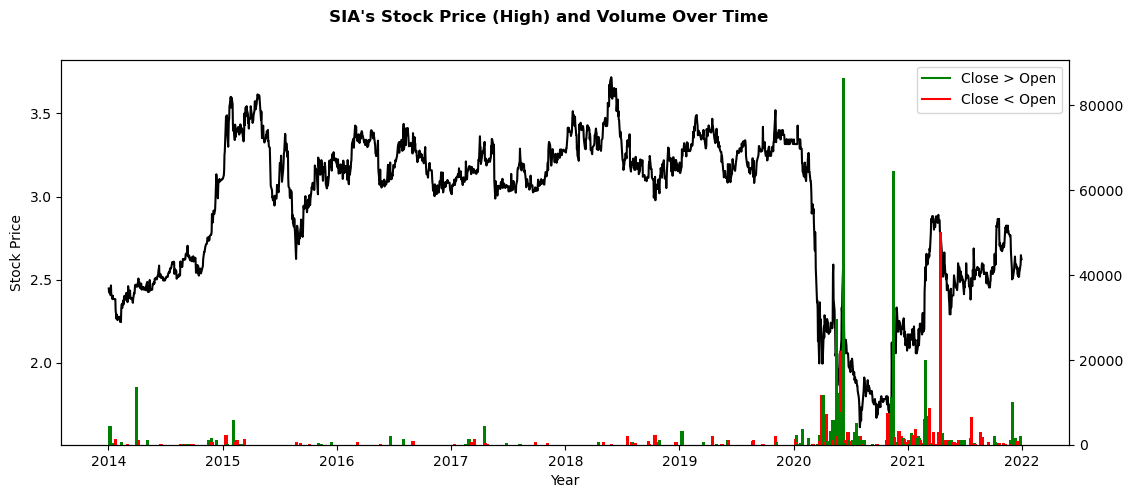

In [8]:
# set bar colors
# green if today's close price > today's open price; red for the opposite
colors = []
for idx, row in data.iterrows():
    if row['Close'] > row['Open']:
        colors.append('green')
    elif row['Close'] < row['Open']:
        colors.append('red')

fig, ax1 = plt.subplots(figsize=(13,5))

ax1.plot(training_df.index, training_df['High'], color='black', label='High')

# second axis for volume
ax2 = ax1.twinx()
ax2.bar(training_df.index, training_df['Volume'], width=10, color=colors)

# formatting
ax1.set_xlabel('Year')
ax1.set_ylabel('Stock Price')
ax2.set_xlabel('Volume')
fig.suptitle("SIA's Stock Price (High) and Volume Over Time", fontweight='bold')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='green'),
                Line2D([0], [0], color='red')]

ax2.legend(custom_lines, ['Close > Open', 'Close < Open'])


plt.show()

The line chart above shows the trend of SIA's highest daily stock price over time. The stock price increased significantly from 2014 to 2015, then slowly declined from 2015 to 2020. What's interesting is that in early 2020 (Jan-Feb), the stock price dipped significantly due to the COVID-19 crisis, where the airline industry was severely affected. In response (few months later), the volume traded siginificantly rose significantly, likely because many people believed that the stock price is likely to return to pre-Covid levels, or increase as Singapore transits out of the pandemic.

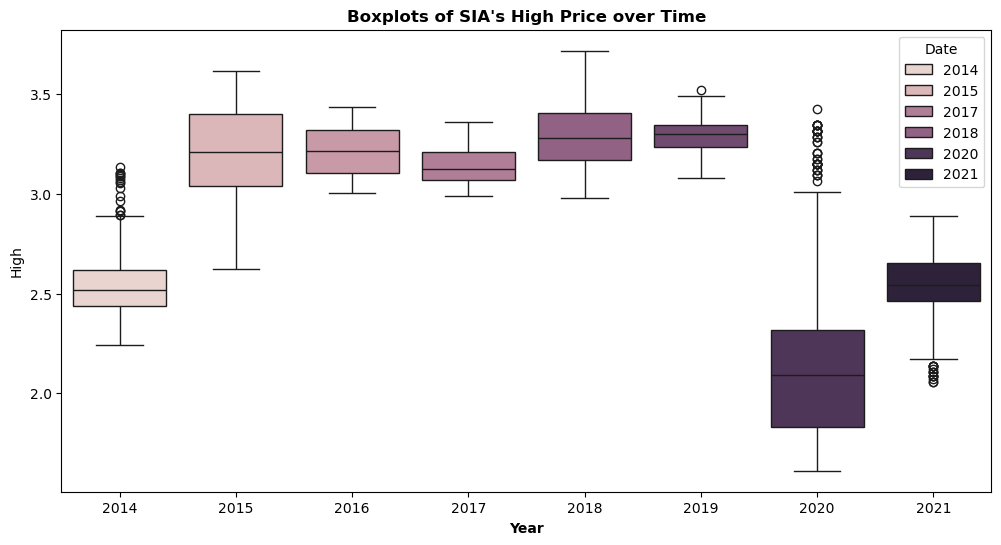

In [9]:
year = training_df.index.year.unique()

fig = plt.figure(figsize=(12,6))
sns.boxplot(x=training_df.index.year, y= training_df['High'], hue=training_df.index.year)

plt.xlabel('Year', fontweight='bold')
plt.title("Boxplots of SIA's High Price over Time", fontweight='bold')

plt.show()

With the earlier observations in mind, we look at the boxplot distribution of SIA's daily high price over time. We can see that there are many outliers in 2014 and 2020, and lesser in 2017 and 2021. Prices are more dispersed in 2015 and 2018, and prices were more scatter in 2015, 2018 and 2020.

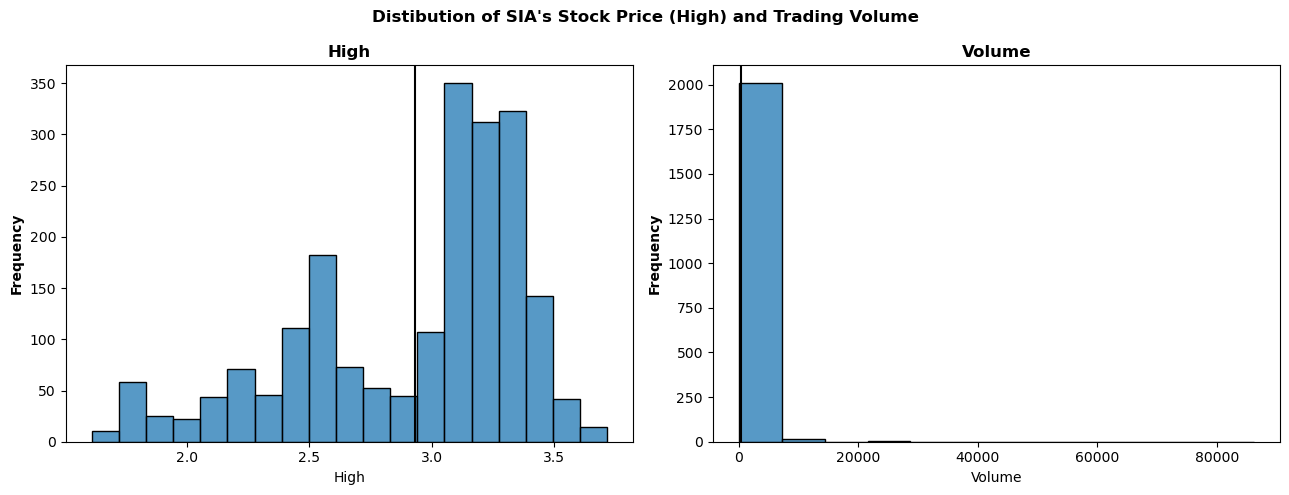

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(13,5))
axes = axes.ravel()

for idx, attr in enumerate(list(training_df.columns)):
    sns.histplot(data = training_df, x = attr, ax = axes[idx], color='tab:blue')
    axes[idx].axvline(x=training_df[attr].mean(), color='black', label='mean')
    axes[idx].set_ylabel('Frequency', fontweight='bold')
    axes[idx].set_title(f"{attr}", fontweight='bold')

plt.suptitle("Distibution of SIA's Stock Price (High) and Trading Volume", fontweight='bold')
plt.tight_layout()
plt.show()

Keeping in mind the earlier observations, we can see the distribution for SIA's daily High stock price and trading volume above.
- The distribution for daily High has has a **bimodal** shape, likely due to the **price dip in 2020**. 
- SIA's stock price was somewhat consistently trading between **SGD $6 to $8**, hence most of the stock price values lie within that range.
- Volume-wise, the distribution is **very left-skewed** since there are outliers, especially in 2020.

## **Data Preprocessing and Normalisation**

The LSTM network requires a 3D array as input, and we want it to process the stock price and volume in sequence (based on time), so we will split `training_df` and `test_df` on a rolling-window basis of 52 days to form `x_train`, `y_train`, and `x_test`, `y_test`. 

*i.e., Day 1 to 52 of `training_df` is counted as `x_train`, and the stock price on the 53rd day is `y_train`; Day 2 to 5 is `x_train`, Day 54's stock price is `y_train`.  *
   
- This will allow the LSTM network to analyse the stock price and volume of the first 52 days, and then use that to predict the 53rd day's `High`, and evaluate it against the true value for the 53rd day. 
- Then, it will move to the next sequence (Day 2 to 53) and predict `High` for the 54th day, until it reaches the end of the training dataset.  
  
We also need to scale the values using `MinMaxScaler()` as the stock price and trading volumes have very contrasting numbers.

In [11]:
x_train, y_train, x_test, y_test = [], [], [], []

offset = 52

for idx in range(offset, training_df.shape[0]):
    start = idx - offset
    x_train.append(training_df.iloc[start:idx].values)
    y_train.append(training_df.iloc[idx, 0])

for idx in range(offset, test_df.shape[0]):
    start = idx - offset
    x_test.append(test_df.iloc[start:idx].values)
    y_test.append(test_df.iloc[idx, 0])

x_val = x_train[-round(0.2*len(x_train)):]
y_val = y_train[-round(0.2*len(x_train)):]

x_train, y_train, x_val, y_val, x_test, y_test = np.array(x_train[:-round(0.2*len(x_train))]), np.array(y_train[:-round(0.2*len(x_train))]), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)

print(f"Number of records for x_train: {x_train.shape}")
print(f"Number of records for x_val: {x_val.shape}")
print(f"Number of records for x_test: {x_test.shape}")

print(f"Number of records for y_train: {y_train.shape}")
print(f"Number of records for y_val: {y_val.shape}")
print(f"Number of records for y_test: {y_test.shape}")

Number of records for x_train: (1582, 52, 2)
Number of records for x_val: (395, 52, 2)
Number of records for x_test: (205, 52, 2)
Number of records for y_train: (1582,)
Number of records for y_val: (395,)
Number of records for y_test: (205,)


In [12]:
# normalise data using MixMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# reshape arrays for scaling
x_train_scaled = scaler_x.fit_transform(x_train.reshape(x_train.shape[0], -1)) # (1582, 52*2)
x_val_scaled = scaler_x.transform(x_val.reshape(x_val.shape[0], -1)) # (395, 52*2)
x_test_scaled = scaler_x.transform(x_test.reshape(x_test.shape[0], -1))  # (205, 52*2)

# reshape back to original
x_train_scaled = x_train_scaled.reshape(x_train.shape)
x_val_scaled = x_val_scaled.reshape(x_val.shape)
x_test_scaled = x_test_scaled.reshape(x_test.shape)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)) # (1582, 1)
y_val_scaled = scaler_y.transform(y_val.reshape(-1,1)) # (395, 1)
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1))  # (205, 1)


In [13]:

print(f"Number of records for x_train_scaled: {x_train_scaled.shape}")
print(f"Number of records for y_train_scaled: {y_train_scaled.shape}")
print(f"Number of records for x_val_scaled: {x_val_scaled.shape}")
print(f"Number of records for y_val_scaled: {y_val_scaled.shape}")
print(f"Number of records for x_test_scaled: {x_test_scaled.shape}")
print(f"Number of records for y_test_scaled: {y_test_scaled.shape}")

Number of records for x_train_scaled: (1582, 52, 2)
Number of records for y_train_scaled: (1582, 1)
Number of records for x_val_scaled: (395, 52, 2)
Number of records for y_val_scaled: (395, 1)
Number of records for x_test_scaled: (205, 52, 2)
Number of records for y_test_scaled: (205, 1)


## **Create LSTM Networks**
- The number of units for the LSTM layer is 100 as we want at least 100 dimensions for our output
- The number of units for the Dense layer is 1 because our output is only 1 value, which the `High` price for the next day.
- The number of epochs is set at 50 for each model.

For this question, we are constructing 3 models, each with different optimizers to identify most appropriate optimizer.
1. `Adam`
2. `SGD`
3. `RMSProp`
  
For each model, we will assess performance based on 4 metrics:
- `Mean Squared Error (MSE)`: Measures average squared differences between predicted stock prices and actual stock prices. The lower it is, the better. MSE tends to penalise larger differnnces, which is why the MAE and MAPE comes in handy.
- `Mean Absolute Error (MAE)`: Measures the av.absolute difference b/w predicted and actual stock prices; the lower the better. MAE, though, is on the same scale as the target variable (price), which makes it difficullt to interpret the range of values, so that's why MAPE is useful.
- `Mean Absolute Percentage Error (MAPE)`: The mean of all absolute percentage differnces b/w predicted and actual stock prices. The error is a %, so it is easy to understand. Not useful if actual stock prices are close to 0, but we don't have that issue.
- `R2 Score`: Measures how well the previous 52 days' stock prices and trading volumes explain the variability of the predicted stock price. Value between 0-1.Too high of a value could mean overfitting.

In [14]:
print('Building Model 1...')
print("Optimizer = 'adam'")

model1 = Sequential()
model1.add(LSTM(128, input_shape = (x_train.shape[1], 2)))
model1.add(Dense(1))
print(model1.summary())

model1.compile(loss='mse',
              optimizer = 'adam',
              metrics = [MeanAbsoluteError(), MeanAbsolutePercentageError(), R2Score()])

print('Training the model1...')
adam = model1.fit(x_train_scaled, y_train_scaled,
                    batch_size = 32,
                    epochs = 50,
                    validation_data = (x_val_scaled, y_val_scaled))

y_pred_adam = model1.predict(x_test_scaled)

Building Model 1...
Optimizer = 'adam'

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67072     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 67201 (262.50 KB)
Trainable params: 67201 (262.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None

Training the model1...
Epoch 1/50

50/50 [==============================] - 2s 20ms/step - loss: 0.0388 - mean_absolute_error: 0.1196 - mean_absolute_percentage_error: 168575.4531 - r2_score: -0.2882 - val_loss: 0.0098 - val_mean_absolute_error: 0.0870 - val_mean_absolute_percentage_error: 1135187.6250 - val_r2_score: 0.7332
Epoch 2/50
50/50 [=======================

In [15]:
print('Building Model 2...')
print("Optimizer = 'SGD'")
model2 = Sequential()
model2.add(LSTM(128, input_shape = (x_train.shape[1], 2)))
model2.add(Dense(1))
print(model2.summary())

model2.compile(loss='mse',
              optimizer = 'sgd',
              metrics = [MeanAbsoluteError(), MeanAbsolutePercentageError(), R2Score()])

print('Training the model...')
sgd = model2.fit(x_train_scaled, y_train_scaled,
                    batch_size = 32,
                    epochs = 50,
                    validation_data = (x_val_scaled, y_val_scaled))

y_pred_sgd = model2.predict(x_test_scaled)

Building Model 2...
Optimizer = 'SGD'
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               67072     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67201 (262.50 KB)
Trainable params: 67201 (262.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Training the model...
Epoch 1/50
50/50 [==============================] - 2s 16ms/step - loss: 0.0616 - mean_absolute_error: 0.1712 - mean_absolute_percentage_error: 295668.7812 - r2_score: -1.0448 - val_loss: 0.0837 - val_mean_absolute_error: 0.2642 - val_mean_absolute_percentage_error: 3884043.0000 - val_r2_score: -1.2879
Epoch 2/50
50/50 [=========================

In [16]:
print('Building Model 2...')
print("Optimizer = 'RMSProp")
model3 = Sequential()
model3.add(LSTM(128, input_shape = (x_train.shape[1], 2)))
model3.add(Dense(1))
print(model3.summary())

model3.compile(loss='mse',
              optimizer = 'RMSprop',
              metrics = [MeanAbsoluteError(), MeanAbsolutePercentageError(), R2Score()])

print('Training the model...')
rms = model3.fit(x_train_scaled, y_train_scaled,
                    batch_size = 32,
                    epochs = 50,
                    validation_data = (x_val_scaled, y_val_scaled))

y_pred_rms = model3.predict(x_test_scaled)

Building Model 2...
Optimizer = 'RMSProp
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               67072     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67201 (262.50 KB)
Trainable params: 67201 (262.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Training the model...
Epoch 1/50
50/50 [==============================] - 2s 16ms/step - loss: 0.0232 - mean_absolute_error: 0.0936 - mean_absolute_percentage_error: 157537.6094 - r2_score: 0.2302 - val_loss: 0.0113 - val_mean_absolute_error: 0.0973 - val_mean_absolute_percentage_error: 984779.1250 - val_r2_score: 0.6905
Epoch 2/50
50/50 [=========================

In [17]:
# get predicted stock prices (y_pred)
predicted_price_adam = scaler_y.inverse_transform(y_pred_adam)
predicted_price_sgd = scaler_y.inverse_transform(y_pred_sgd)
predicted_price_rms = scaler_y.inverse_transform(y_pred_rms)

## **Metrics**

In [18]:
# get all metrics for train & val data
adam_metrics_tv = {}
sgd_metrics_tv = {}
rms_metrics_tv = {}

txt_adam = 'Model 1 (Adam)\n'
txt_sgd = 'Model 2 (SGD)\n'
txt_rms = 'Model 3 (RMS)\n'

for k in adam.history.keys():
    adam_metrics_tv[k] = adam.history[k]
    sgd_metrics_tv[k] = sgd.history[k]
    rms_metrics_tv[k] = rms.history[k]
    
    txt_adam += f"{k.title().replace('_', ' ')}: {sum(adam.history[k])/len(adam.history[k]):.5f}\n"
    txt_sgd += f"{k.title().replace('_', ' ')}: {sum(sgd.history[k])/len(sgd.history[k]):.5f}\n"
    txt_rms += f"{k.title().replace('_', ' ')}: {sum(rms.history[k])/len(rms.history[k]):.5f}\n" 

keys = list(adam.history.keys())
train_metrics_keys = keys[:4]
val_metrics_keys = keys[4:]

print(train_metrics_keys)
print(val_metrics_keys)

['loss', 'mean_absolute_error', 'mean_absolute_percentage_error', 'r2_score']
['val_loss', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error', 'val_r2_score']


In [19]:
# get all metrics for test data
# model 1 - adam
adam_test_mse = mean_squared_error(y_test, predicted_price_adam)
adam_test_mae = mean_absolute_error(y_test, predicted_price_adam)
adam_test_mape = mean_absolute_percentage_error(y_test, predicted_price_adam)
adam_test_r2 = r2_score(y_test, predicted_price_adam)

print(txt_adam)    
print(f"Test MSE: {adam_test_mse:.5f}")
print(f"Test MAE: {adam_test_mae:.5f}")
print(f"Test MAPE: {adam_test_mape:.5f}")
print(f"Test R2 Score: {adam_test_r2:.5f}\n\n")

# model 2 - sgd
sgd_test_mse = mean_squared_error(y_test, predicted_price_sgd)
sgd_test_mae = mean_absolute_error(y_test, predicted_price_sgd)
sgd_test_mape = mean_absolute_percentage_error(y_test, predicted_price_sgd)
sgd_test_r2 = r2_score(y_test, predicted_price_sgd)

print(txt_sgd)
print(f"Test MSE: {sgd_test_mse:.5f}")
print(f"Test MAE: {sgd_test_mae:.5f}")
print(f"Test MAPE: {sgd_test_mape:.5f}")
print(f"Test R2 Score: {sgd_test_r2:.5f}\n\n")

# model 3 - rmsprop
rms_test_mse = mean_squared_error(y_test, predicted_price_rms)
rms_test_mae = mean_absolute_error(y_test, predicted_price_rms)
rms_test_mape = mean_absolute_percentage_error(y_test, predicted_price_rms)
rms_test_r2 = r2_score(y_test, predicted_price_rms)
print(txt_rms)
print(f"Test MSE: {rms_test_mse:.5f}")
print(f"Test MAE: {rms_test_mae:.5f}")
print(f"Test MAPE: {rms_test_mape:.5f}")
print(f"Test R2 Score: {rms_test_r2:.5f}")

Model 1 (Adam)
Loss: 0.00193
Mean Absolute Error: 0.02566
Mean Absolute Percentage Error: 78601.91617
R2 Score: 0.93590
Val Loss: 0.00230
Val Mean Absolute Error: 0.03576
Val Mean Absolute Percentage Error: 235182.89344
Val R2 Score: 0.93719

Test MSE: 0.00139
Test MAE: 0.02801
Test MAPE: 0.00940
Test R2 Score: 0.87701


Model 2 (SGD)
Loss: 0.00395
Mean Absolute Error: 0.03779
Mean Absolute Percentage Error: 138886.85219
R2 Score: 0.86895
Val Loss: 0.01092
Val Mean Absolute Error: 0.07016
Val Mean Absolute Percentage Error: 849047.35000
Val R2 Score: 0.70124

Test MSE: 0.00337
Test MAE: 0.04675
Test MAPE: 0.01566
Test R2 Score: 0.70255


Model 3 (RMS)
Loss: 0.00176
Mean Absolute Error: 0.02787
Mean Absolute Percentage Error: 52103.18570
R2 Score: 0.94164
Val Loss: 0.00158
Val Mean Absolute Error: 0.02982
Val Mean Absolute Percentage Error: 232662.84016
Val R2 Score: 0.95679

Test MSE: 0.00130
Test MAE: 0.02645
Test MAPE: 0.00885
Test R2 Score: 0.88525


## **Model Evaluation**
- The 4 metrics were computed for training data, validation data and test data, for each model.
- Looking at only the metrics, Model 2, which is optimised using SGD, has performed most poorly as its overall MSE, MAE, and MAPE are higher compared to the other 2 models. 
- Model 1 and 3 perform quite similarly, but Model 3, which is optimised using RMSProp, has the lowest error values in general across the training, validation and test data.

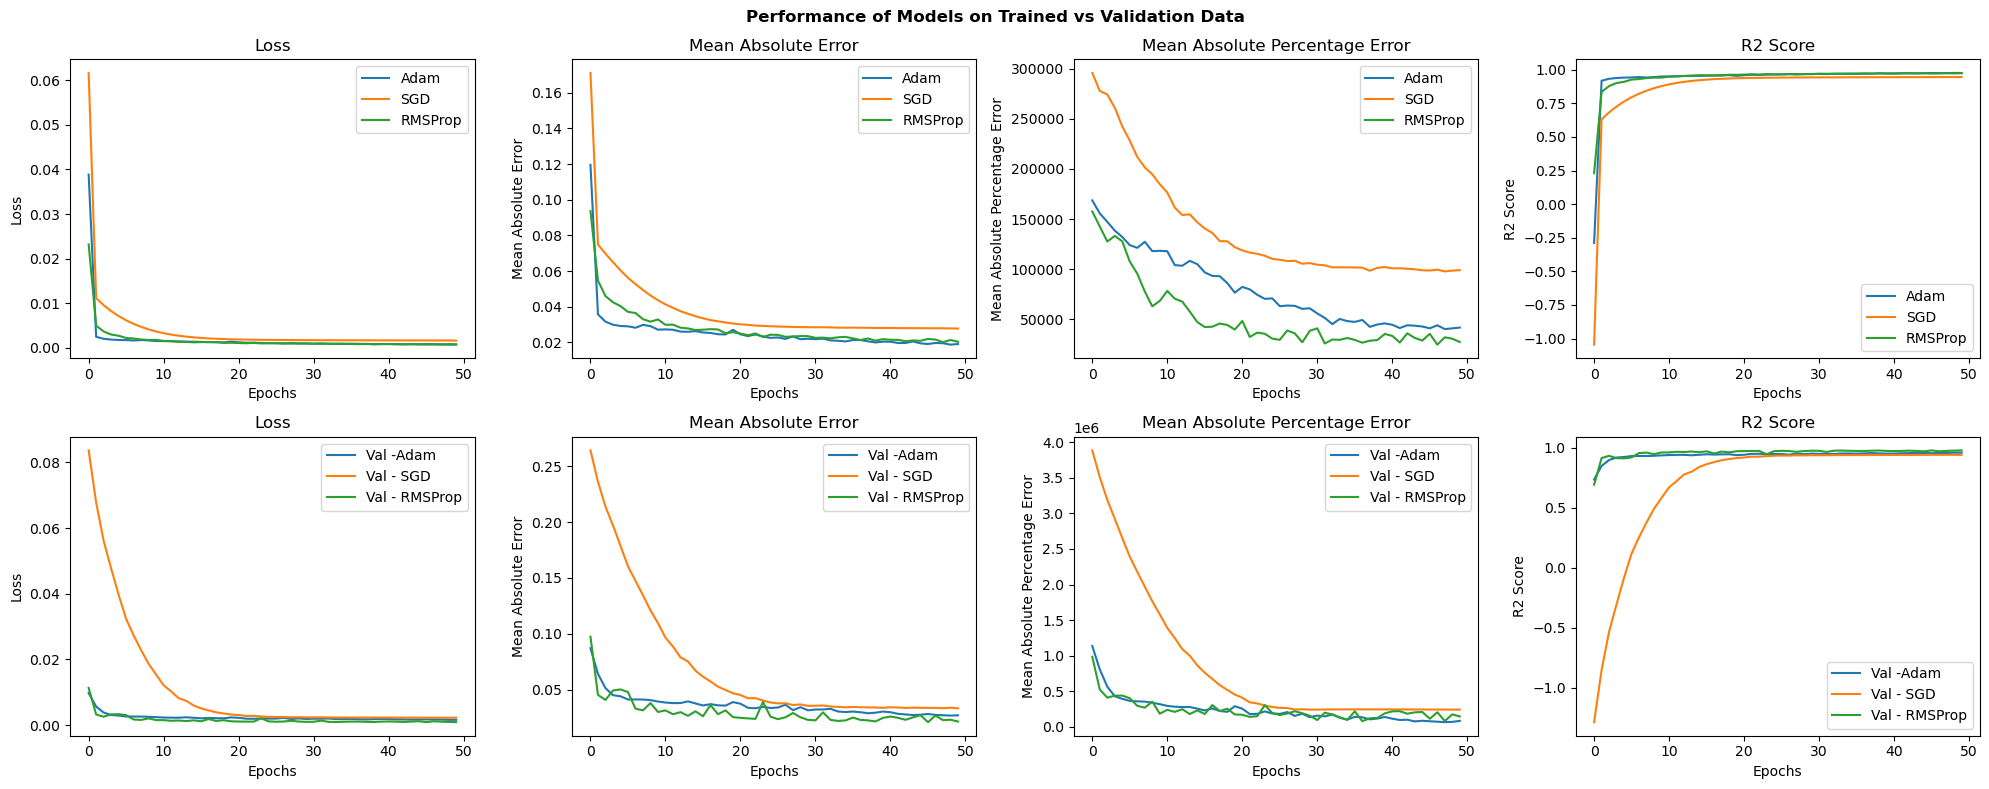

In [20]:
epochs = range(50)

# compare metrics for training data across the 3 different models
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.ravel()

for idx, attr in enumerate(train_metrics_keys):
    # train
    axes[idx].plot(epochs, adam_metrics_tv[train_metrics_keys[idx]], label='Adam')
    axes[idx].plot(epochs, sgd_metrics_tv[train_metrics_keys[idx]], label='SGD')
    axes[idx].plot(epochs, rms_metrics_tv[train_metrics_keys[idx]], label='RMSProp')
        
    axes[idx].legend()
    axes[idx].set_title(f"{train_metrics_keys[idx].title().replace('_', ' ')}")
    axes[idx].set_xlabel('Epochs')
    axes[idx].set_ylabel(train_metrics_keys[idx].title().replace('_', ' '))
    
    # val
    axes[idx+4].plot(epochs, adam_metrics_tv[val_metrics_keys[idx]], label='Val -Adam')
    axes[idx+4].plot(epochs, sgd_metrics_tv[val_metrics_keys[idx]], label='Val - SGD')
    axes[idx+4].plot(epochs, rms_metrics_tv[val_metrics_keys[idx]], label='Val - RMSProp')
    
    axes[idx+4].legend()
    axes[idx+4].set_title(f"{train_metrics_keys[idx].title().replace('_', ' ')}")
    axes[idx+4].set_xlabel('Epochs')
    axes[idx+4].set_ylabel(train_metrics_keys[idx].title().replace('_', ' '))

fig.suptitle('Performance of Models on Trained vs Validation Data', fontweight='bold')
fig.tight_layout()

plt.show()

- Visually, we can see that **Model 2 (`SDG`)** has higher error values in general, and its MAPE shows the true absolute error differences in comparison to MAE - slope of the line chart is more gentle for MAPE.  
- Both Models 1 and 3 perform well but **Model 3 (`RMSProp`)** has lower error values for the testing dataset.

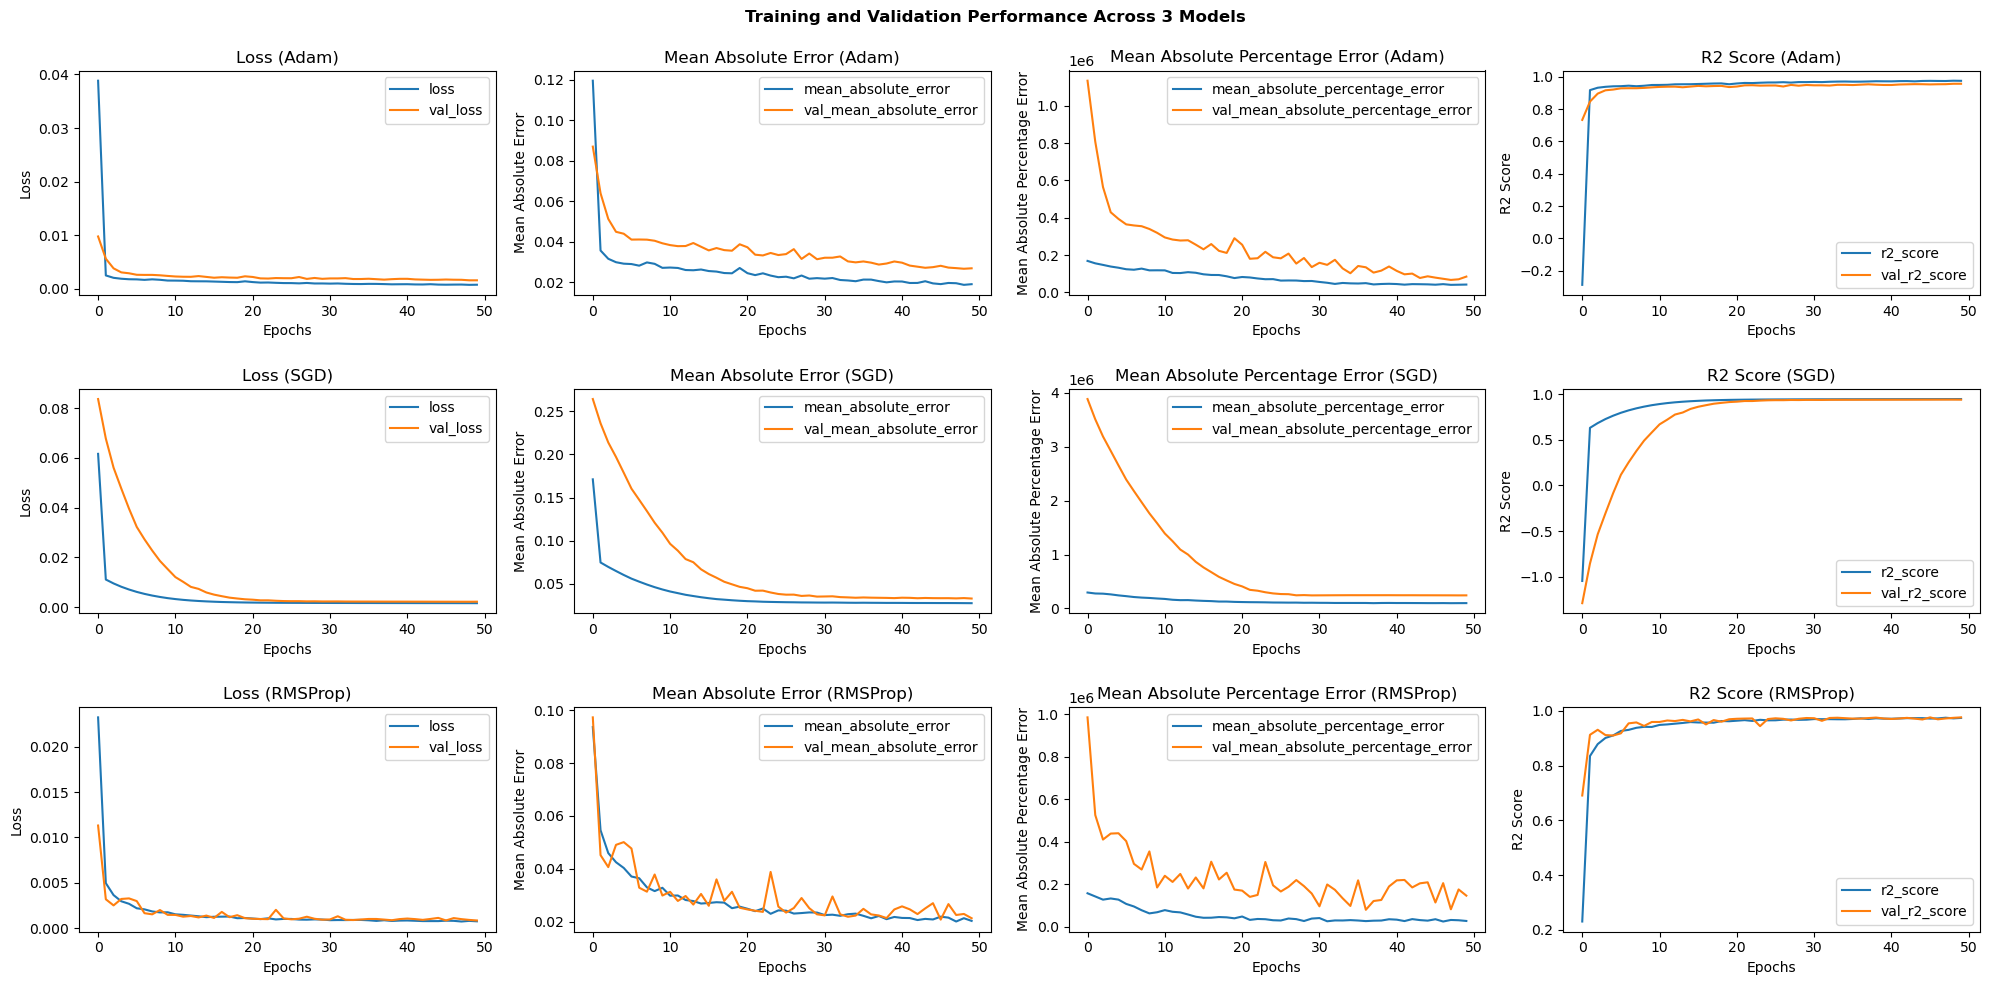

In [21]:
# compare metrics for training data across the 3 different models
fig, axes = plt.subplots(3, 4, figsize=(20,10))
axes = axes.ravel()

for idx, key in enumerate(val_metrics_keys):  
    # adam
    axes[idx].plot(epochs, adam_metrics_tv[train_metrics_keys[idx]], label=train_metrics_keys[idx]) # train
    axes[idx].plot(epochs, adam_metrics_tv[val_metrics_keys[idx]], label=val_metrics_keys[idx]) # val
    axes[idx].legend()
    axes[idx].set_title(f"{train_metrics_keys[idx].title().replace('_', ' ')} (Adam)")
    axes[idx].set_xlabel('Epochs')
    axes[idx].set_ylabel(train_metrics_keys[idx].title().replace('_', ' '))
    
    # sgd
    axes[idx+4].plot(epochs, sgd_metrics_tv[train_metrics_keys[idx]], label=train_metrics_keys[idx]) # train
    axes[idx+4].plot(epochs, sgd_metrics_tv[val_metrics_keys[idx]], label=val_metrics_keys[idx]) # val
    axes[idx+4].legend()
    axes[idx+4].set_title(f"{train_metrics_keys[idx].title().replace('_', ' ')} (SGD)")
    axes[idx+4].set_xlabel('Epochs')
    axes[idx+4].set_ylabel(train_metrics_keys[idx].title().replace('_', ' '))
    
    # rms
    axes[idx+8].plot(epochs, rms_metrics_tv[train_metrics_keys[idx]], label=train_metrics_keys[idx]) # train
    axes[idx+8].plot(epochs, rms_metrics_tv[val_metrics_keys[idx]], label=val_metrics_keys[idx]) # val
    axes[idx+8].legend()
    axes[idx+8].set_title(f"{train_metrics_keys[idx].title().replace('_', ' ')} (RMSProp)")
    axes[idx+8].set_xlabel('Epochs')
    axes[idx+8].set_ylabel(train_metrics_keys[idx].title().replace('_', ' '))

fig.suptitle('Training and Validation Performance Across 3 Models', fontweight='bold')
fig.tight_layout()

plt.show()

Here, we compare the metrics generated for trained data against the validation data to see how the models have performed on the validation data.  

### **Model 1: Adam**
- The MAPE is slightly higher than Model 3, meaning its percentage error is marginally worse. However, the difference is small, and both optimizers are effective.
  - *Difference between predicted price and the actual price in the validation set, divided by the actual price, is much larger than the dollar difference (MAE).*  

### **Model 2: SGD**
- Meanwhile, Model 2's overall error values and r2 score are **smoother** - there are **lesser flucuations** within the error values, so predicted values are more consistent compared to the other 2 models (due to the *SGD optimisation process*).  
- The r2 score is negative for the first 10+ epochs, before converging towards 0, which means that much of the variance between in the predicted stock prices cannot be explained/predicted from the inputs provided to the LSTM network. It explains why the MSE, MAE and MAPE are overall higher than the other 2 models. Optimising LSTM regressors for stock price data using **SGD** is likely **unsuitable**.  

### **Model 3: RMSProp**
- The MSE and MAE are largely similar to **Model 1**. In terms of MSE and MAE, since the error values for the validation dataset are lower, it typially indicates that the model has good generalisation performance - it can predict stock prices quite accurately based on unseen data.
- Model 3's MAPE values are generally lower than that of Model 1's, albeit slightly. 
- The r2 score for Model 1 is also slightly better than Model 1 in the sense that the model performed between on the validation set.

### **Final Remarks**
- Something to note is that the validation dataset likely comes from 2021, while the model was trained on data from 2014 to COVID period (2020), where the stock prices for SIA were much higher. In contrast, the values for the validation set and test set are much more different, both in terms of stock price and the trading volume.

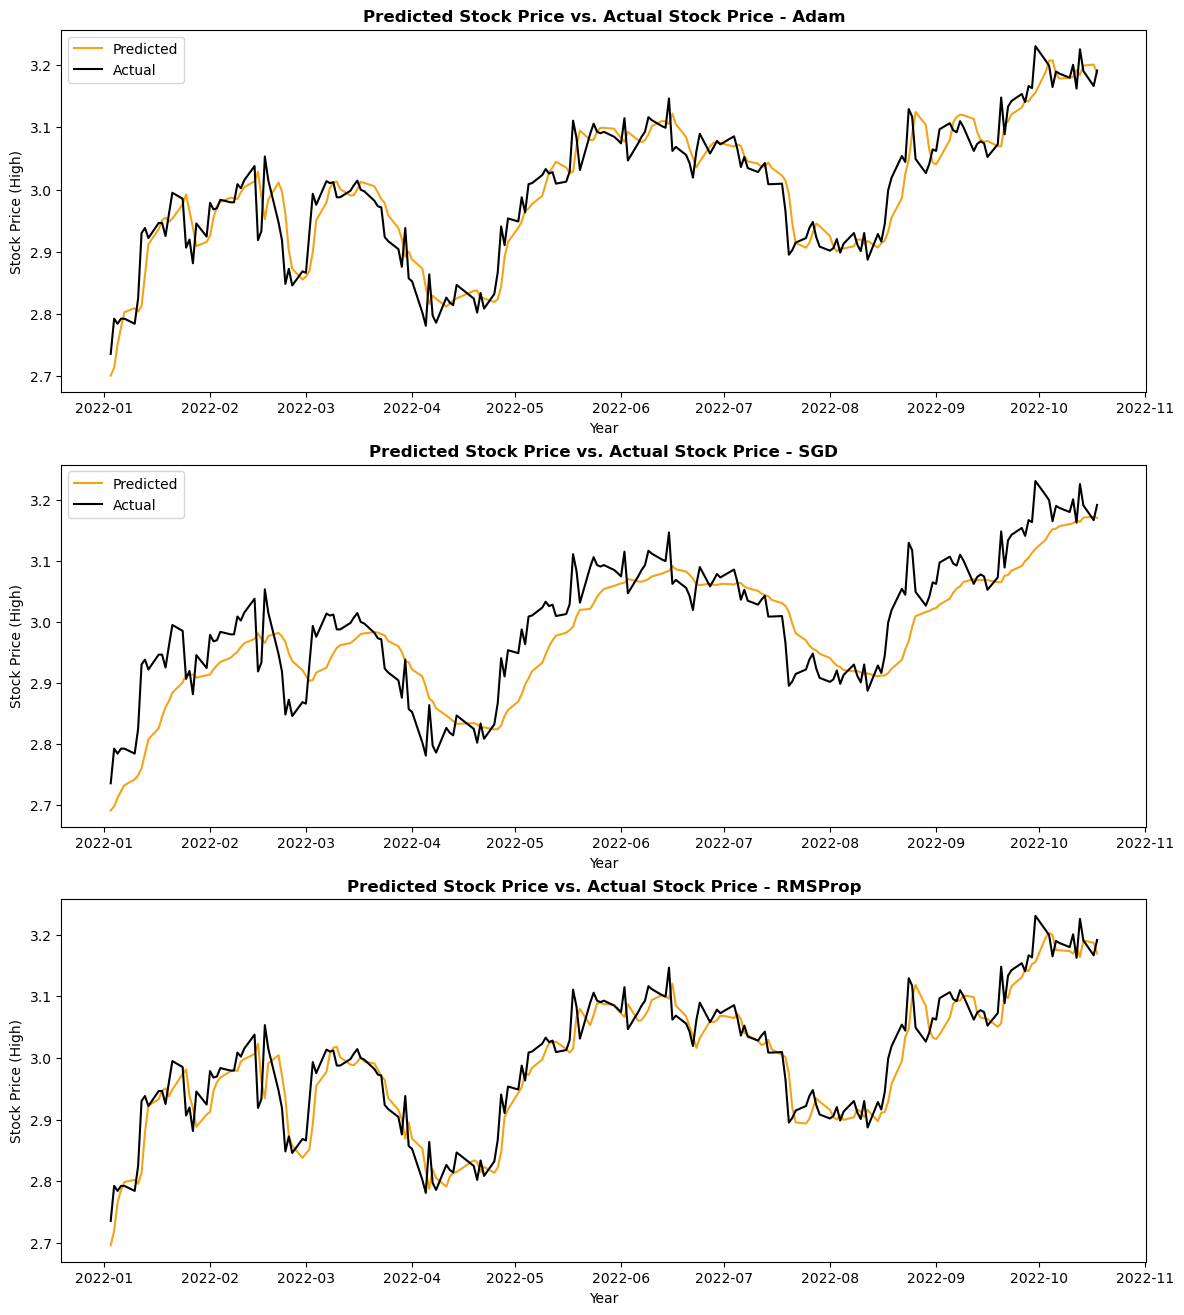

In [22]:
# visualise predicted stock prices vs actual stock prices
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14,16))

# model 1: adam
ax1.plot(test_df.index[:predicted_price_adam.shape[0]], predicted_price_adam, label='Predicted', color='#f5a316')
ax1.plot(test_df.index[:predicted_price_adam.shape[0]], y_test, label='Actual', color='black')
ax1.set_xlabel('Year')
ax1.set_ylabel('Stock Price (High)')
ax1.set_title('Predicted Stock Price vs. Actual Stock Price - Adam', weight='bold')

# model 2: SDG
ax2.plot(test_df.index[:predicted_price_sgd.shape[0]], predicted_price_sgd, label='Predicted', color='#f5a316')
ax2.plot(test_df.index[:predicted_price_sgd.shape[0]], y_test, label='Actual', color='black')
ax2.set_xlabel('Year')
ax2.set_ylabel('Stock Price (High)')
ax2.set_title('Predicted Stock Price vs. Actual Stock Price - SGD', weight='bold')

# model 3: RMSProp
ax3.plot(test_df.index[:predicted_price_rms.shape[0]], predicted_price_rms, label='Predicted', color='#f5a316')
ax3.plot(test_df.index[:predicted_price_rms.shape[0]], y_test, label='Actual', color='black')
ax3.set_xlabel('Year')
ax3.set_ylabel('Stock Price (High)')
ax3.set_title('Predicted Stock Price vs. Actual Stock Price - RMSProp', weight='bold')

ax1.legend()
ax2.legend()

plt.show()

The best evaluation is to visualise the predicted stock prices against the actual stock prices to see how each model has fared.

### **Analysis**  
Overall, we can see that **Model 2**'s predictions are very different from the actual values, and visually, the predicted stock prices seem to reflect a time lag. E.g., In early 2022 August the stock price went up, but the price surge is only reflected in the predicted values nearing the tail end of August 2022. The overall line chart is also much smoother, when in reality the stock market is never smooth. For predicting stock market data, SDG is not an appropriate optimizer.  
  
As for **Model 1 and 3**, they have performed relatively well - the predicted stock prices largely follows the trends in the actual stock prices values, and each of the line charts capture to a certain extent the fluctuations in SIA's stock price in 2022. However, it is still clear that Model 3's predicted values are very close to the actual stock prices, given how close the predicted line (in orange) is to the actual values (black line).The time lag between the predicted and actual values is also less prominent.  

### **Overall Conclusion**
- `RMSProp` is the **best optimizer** for LSTM-based stock price prediction, but `Adam` also performs well, making it a viable alternative.
- Other parameters like `batch_size`, `units`, and `number of epochs` also play a part. From the earlier charts, we can see that **most error values tend to converge towards 0 by the 5th to 10th epoch**, except for SGD, which moves towards 0 around **Epoch 20**.